In [63]:
# import pandas as pd
import MagmaPandas as mp
import MagmaPandas.geochemistry.PEC as pec
import pandas as pd
import elements as e
import matplotlib.pyplot as plt
import meltInc.plotting as p

p.layout()
config = pec.PEC_configuration()
config.print()

############## Post-entrapment modification #############
#################### correction model ###################

Settings________________________________________________
Stepsize equilibration (moles).....................0.002 
Stepsize crystallisation (moles)...................0.05  
Decrease factor....................................5     
FeO convergence (wt. %)............................0.05  
Kd convergence.....................................0.0001
Temperature convergence (°)........................0.1   


In [2]:
melt = mp.read_melt_inclusion('./melt.csv', index_col=['name'], total_col='total')
olivine = mp.read_olivine('./olivine.csv', index_col=['name'], total_col="total")

In [3]:
forsterites = olivine.forsterite
inclusions = melt.copy()
ol_host = olivine.copy()
Fo = 0.9
# FeO_initial = 11.2
FeO_initial = lambda x: 12 - 0.2 * x["MgO"]
P_bar = 2e3

In [4]:
equilibrated_inclusions = mp.MagmaFrame(index=inclusions.index, columns=inclusions.columns, dtype=float, units="wt. %", datatype="oxide")
ol_equilibrated = pd.Series(index=inclusions.index, dtype=float)

totalItems= equilibrated_inclusions.shape[0]
for i, ((idx, mi), (_, ol)) in enumerate(zip(inclusions.iterrows(), ol_host.iterrows())):

    print(f"{i + 1:0>3}/{totalItems:0>3} inclusions equilibrated", end= "\r")
    x, oc, kd = pec.Fe_equilibrate(mi, ol, P_bar)
    equilibrated_inclusions.loc[idx] = x.iloc[-1]
    ol_equilibrated.loc[idx] = oc[-1]

In [5]:
corrected_inclusions = mp.Melt(index=inclusions.index, columns=inclusions.columns, dtype=float, units="wt. %", datatype="oxide")
ol_crystallised = pd.Series(index=inclusions.index, dtype=float)

totalItems = equilibrated_inclusions.shape[0]

for i, ((idx, mi), (_, ol)) in enumerate(zip(equilibrated_inclusions.iterrows(), ol_host.iterrows())):

    print(f"{i + 1:0>3}/{totalItems:0>3} inclusions corrected", end= "\r")

    x2, oc2, kd2, t = pec.crystallisation_correction(mi, ol, FeO_initial, P_bar)
    corrected_inclusions.loc[idx] = x2.iloc[-1]
    ol_crystallised.loc[idx] = oc2[-1]

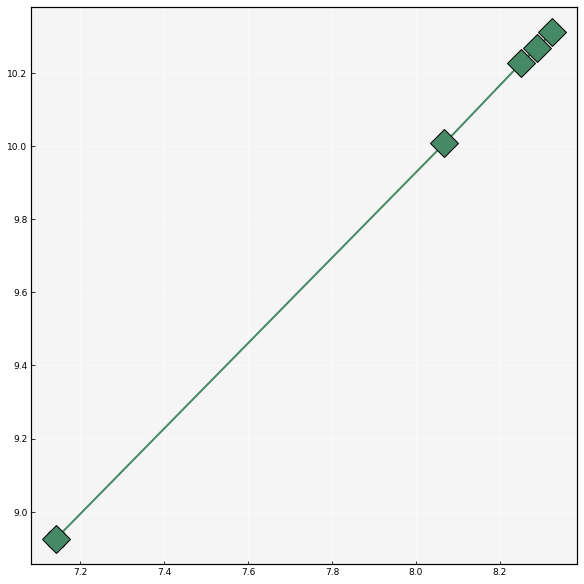

In [6]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(x["MgO"], x["FeO"], "-o")
plt.plot(x2["MgO"], x2["FeO"], "-D")


In [7]:
mi_pec = pec.PEC_olivine(inclusions, ol_host, P_bar, FeO_initial)

In [8]:
mi_pec.reset()
x, oc, t = mi_pec.correct()

029/029 inclusions equilibrated
029/029 inclusions corrected


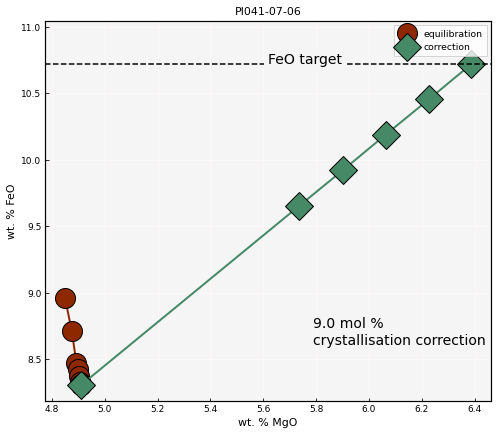

In [9]:
t = mi_pec.correct_inclusion(26)

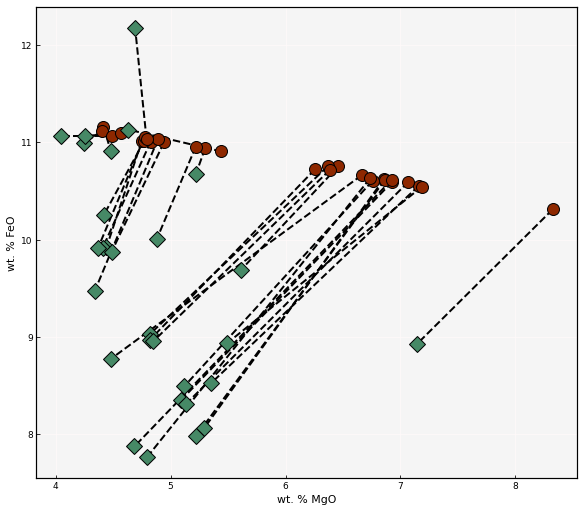

In [94]:
markersize = 12

fig, ax = plt.subplots(figsize=(8,7))

for (idx, i), (_, j) in zip(mi_pec.inclusions.iterrows(), mi_pec.inclusions_uncorrected.iterrows()):
    data = pd.concat([pd.Series(i), pd.Series(j)], axis=1).T
    data.index = ["corrected", "original"]
    plt.plot(data["MgO"], data["FeO"], "--", color="k")

plt.plot(mi_pec.inclusions["MgO"], mi_pec.inclusions["FeO"], "o", markersize=markersize)
plt.plot(mi_pec.inclusions_uncorrected["MgO"], mi_pec.inclusions_uncorrected["FeO"], "D", markersize=markersize)

ax.set_xlabel("wt. % MgO")
ax.set_ylabel("wt. % FeO")

plt.show()